[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/linclab/EG_optimiser/blob/main/example.ipynb)

This is a slightly modified PyTorch MNIST example https://github.com/pytorch/examples/blob/main/mnist/main.py

In [ ]:
!git clone https://github.com/linclab/EG_optimiser.git
%cd EG_optimiser
!pip install -e . --no-deps # use --no-deps if pytorch is already installed (e.g. in Colab)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from optim_eg import adamw_eg, sgd_eg, init_tools
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [2]:
def main(opt='sgd', lr=0.1, use_split_bias=False, use_lognormal_init=False):
    epochs = 2
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    train_kwargs = {'batch_size': 256}
    test_kwargs = {'batch_size': 256}
    if torch.cuda.is_available():
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    
    if use_split_bias:
        init_tools.set_split_bias(model)
    
    if use_lognormal_init:
        mean_std_ratio = 1.5
        init_func = init_tools.lognormal_
        gain = torch.nn.init.calculate_gain('relu')

        for m in model.modules():
            if (isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d)) and m != model.fc2:
                init_tools.lognormal_(m.weight, gain=gain, mode="fan_out", mean_std_ratio=mean_std_ratio)
    
    init_state = deepcopy(model.state_dict())
    
    # Choosing the optimizer
    if opt == 'sgd':
        # vanilla SGD
        optimizer = sgd_eg.SGD(model.parameters(), lr=lr, update_alg='gd', momentum=0.9)
    elif opt == 'sgd_sign':
        optimizer = sgd_eg.SGD(model.parameters(), lr=lr, update_alg='gd', 
                               freeze_gd_signs=True, freeze_gd_signs_th=1e-18, momentum=0.9)
    elif opt == 'sgd_eg':
        optimizer = sgd_eg.SGD(model.parameters(), lr=lr, update_alg='eg', momentum=0.9)
    elif opt == 'adamw_eg':
        optimizer = adamw_eg.AdamWeg(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    
    final_state = model.state_dict()
    
    return init_state, final_state

The SGD implementation has three options: the vanilla SGD, SGD with frozen signs, and (stochastic) EG. All standard PyTorch arguments (momentum, weight decay, etc.) can be used here too. Note that EG often requires larger learning rates than GD.

The AdamEeg only work in the EG variant. It also takes all standard AdamW arguments (like betas). There's no fused option from torch 2.0 though, as we're using the torch 1.13 AdamW implementation for better compatibility. 

In [3]:
for alg, lr in zip(['sgd', 'sgd_sign', 'sgd_eg', 'adamw_eg'], [0.1, 0.1, 1.0, 0.1]):
    print(f'================\nRunning {alg}\n================\n')
    main(alg, lr=lr)

Running sgd

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284747
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.273404
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.283175

Test set: Average loss: 0.0650, Accuracy: 9803/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.102723
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163474
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.069611

Test set: Average loss: 0.0418, Accuracy: 9872/10000 (99%)

Running sgd_sign

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310104
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.232614
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.152990

Test set: Average loss: 0.0666, Accuracy: 9807/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.109587
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.057244
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.115383

Test set: Average loss: 0.0468, Accuracy: 9849/10000 (98%)

Running sgd_eg

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303030
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.313825
Train Epoch: 1 [51200/60000 (85%)]

Both EG and GD with frozen signs can't switch signs. This might be problematic, especially for the bias parameters in normalization layers. We have an option to re-initialize just the bias parameters as a sum of negative and positive biases (although we've only observed minor performance improvements with this approach):
```
init_tools.set_split_bias(model)
```
Theoretically, frozen signs are also an issue for the weights, but we using a similar technique for the weights had minor impact on the performance (while doubling parameter count). 

In [4]:
init_state, final_state = main('sgd_sign', lr=0.1, use_split_bias=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303175
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.228519
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.124348

Test set: Average loss: 0.0711, Accuracy: 9785/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.119375
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.102206
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.096450

Test set: Average loss: 0.0478, Accuracy: 9849/10000 (98%)



In [5]:
# e.g. conv1.bias and conv1.weight become conv1.bias_pos, conv1.bias_neg, conv1.base_layer.weight
init_state.keys()

odict_keys(['conv1.bias_pos', 'conv1.bias_neg', 'conv1.base_layer.weight', 'conv2.bias_pos', 'conv2.bias_neg', 'conv2.base_layer.weight', 'fc1.bias_pos', 'fc1.bias_neg', 'fc1.base_layer.weight', 'fc2.bias_pos', 'fc2.bias_neg', 'fc2.base_layer.weight'])

In [6]:
# the signs stay the same for all parameters
for key in init_state.keys():
    assert torch.all(init_state[key].sign() == final_state[key].sign())

We can also re-init the network to have log-normal weights using
```
init_tools.re_init_network(model, 'relu', mean_std_ratio=1.5)
```
Here mean_std_ratio=1.5 control the shape of the log-normal distribution.

In this example, we don't re-initialize the final layer as it's too small, resulting in a very large initial loss. This is not an issue for larger networks like ResNet50.

In [7]:
init_state, final_state = main('sgd_eg', lr=0.5, use_lognormal_init=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.979739
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.525420
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.280820

Test set: Average loss: 0.1113, Accuracy: 9658/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219662
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.233717
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.296126

Test set: Average loss: 0.0848, Accuracy: 9752/10000 (98%)



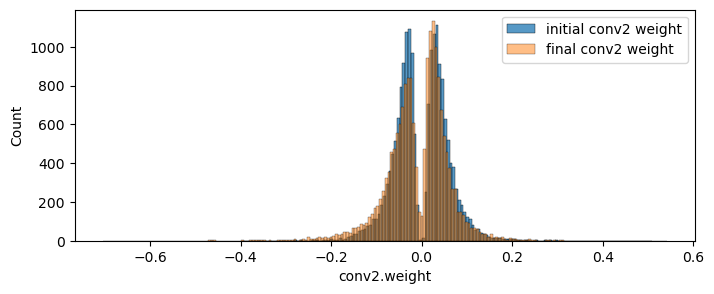

In [8]:
x = init_state['conv2.weight'].flatten().cpu()
y = final_state['conv2.weight'].flatten().cpu()

plt.figure(figsize=(8, 3))
sns.histplot(x, label='initial conv2 weight')
sns.histplot(y, alpha=0.5, label='final conv2 weight')

plt.xlabel('conv2.weight')
plt.legend()
plt.show()